In [30]:
from owslib.csw import CatalogueServiceWeb
from owslib.wms import WebMapService
from owslib.wcs import WebCoverageService
import lxml.etree
import requests

In [2]:
system_endpoint = 'https://resource-catalogue.185.52.193.87.nip.io/'

In [3]:
csw = CatalogueServiceWeb(system_endpoint,timeout=30)

In [4]:
csw.getrecordbyid(id=['S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE'])

In [5]:
links = csw.records['S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE'].references

In [6]:
for link in links:
    scheme = link['scheme']
    if 'WMS' in scheme:
        wms_endpoint=link['url']
        print(link['url'])

https://data-access.185.52.193.87.nip.io/ows?service=WMS&version=1.3.0&request=GetCapabilities&cql=identifier%3D%22S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE%22


In [7]:
wms = WebMapService(wms_endpoint, version='1.3.0')

In [8]:
list(wms.contents)

['S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__outlines',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__outlined',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__FALSE_COLOR',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__NDVI',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__TRUE_COLOR',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__clouds',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__masked_clouds']

In [9]:
wms['S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__TRUE_COLOR'].title

'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__TRUE_COLOR'

In [10]:
wms['S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__TRUE_COLOR'].boundingBoxWGS84

(23.272364192599564, 37.80685703267152, 24.566452796705864, 38.82628170870513)

In [11]:
[op.name for op in wms.operations]

['GetCapabilities', 'GetMap', 'GetFeatureInfo']

In [12]:
wms['S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__TRUE_COLOR'].styles

{}

In [13]:
wms.getOperationByName('GetMap').formatOptions

['image/png', 'image/jpeg', 'image/gif', 'image/tiff']

In [14]:
%matplotlib inline
import os, sys
import matplotlib.image as mpimg
import matplotlib.pyplot as plt

def getMap(wms,layerName,bbox,filename):
    wms.getOperationByName('GetMap').formatOptions
    img = wms.getmap(layers=[layerName],
                 size=(600,300),
                 srs='EPSG:4326',
                 bbox=bbox,
                 format='image/png',
                 transparent=True)

    tmpfile = open(filename,'wb')
    tmpfile.write(img.read())
    tmpfile.close()

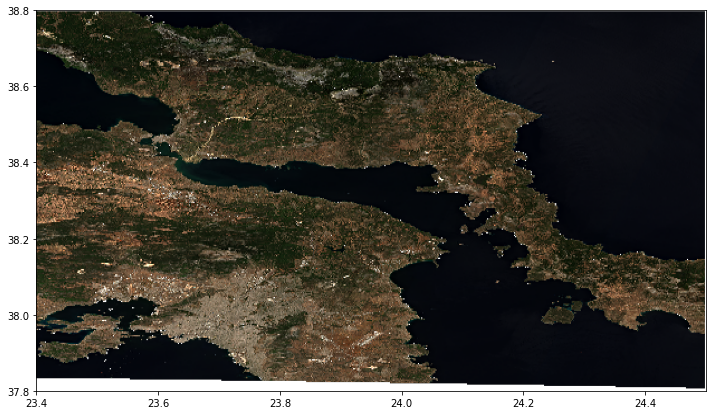

In [15]:
getMap(wms,'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__TRUE_COLOR',(23.4,37.8,24.5,38.8), 'rgb.png')
image1=mpimg.imread('rgb.png')
fig = plt.figure(figsize=(12,7))
img1=plt.imshow(image1,extent=[23.4,24.5,37.8,38.8],aspect='auto')
plt.show()

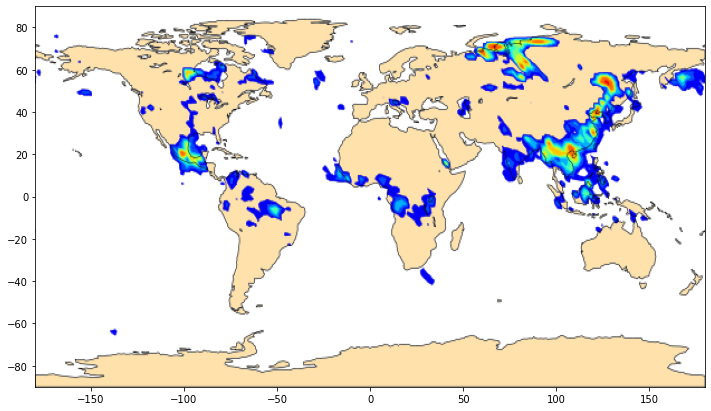

In [16]:
wms2 = WebMapService('http://apps.ecmwf.int/wms/?token=public', version='1.3.0')
getMap(wms2,'foreground',(-180,-90,180,90), 'foreground.png')
getMap(wms2,'background',(-180,-90,180,90), 'background.png')
getMap(wms2,'composition_bbaod550',(-180,-90,180,90), 'bbaod550.png')
image1=mpimg.imread('background.png')
image2=mpimg.imread('bbaod550.png')
image3=mpimg.imread('foreground.png')
fig = plt.figure(figsize=(12,7))

img1=plt.imshow(image1,extent=[-180,180,-90,90],aspect='auto')
img2=plt.imshow(image2,extent=[-180,180,-90,90],aspect='auto')
img3=plt.imshow(image3,extent=[-180,180,-90,90],aspect='auto')
plt.show()

### Folium demo

In [17]:
import os
import folium

print(folium.__version__)

0.12.1


In [18]:
m = folium.Map(location=[38, 24], zoom_start=6, tiles=None)


folium.raster_layers.TileLayer(
    tiles='http://{s}.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
    attr='google',
    name='google maps',
    max_zoom=20,
    subdomains=['mt0', 'mt1', 'mt2', 'mt3'],
    overlay=False,
    control=True,
).add_to(m)

folium.raster_layers.WmsTileLayer(
    url=wms_endpoint,
    layers='S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__TRUE_COLOR',
    name='S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__TRUE_COLOR',
    fmt='image/png',
    overlay=False,
    control=True,
).add_to(m)

folium.LayerControl().add_to(m)

#m.save(os.path.join('results', 'WMS_and_WMTS.html'))

m

### WCS demo

In [34]:
tree = None
for link in links:
    scheme = link['scheme']
    if 'WCS' in scheme:
        wcs_endpoint=link['url'].split('?')[0]
        wcs_id=link['url'].split('eoid=')[1]
        tree = lxml.etree.fromstring(requests.get(link['url']).content)
        break


coverage_ids = tree.xpath('wcs:CoverageDescriptions/wcs:CoverageDescription/@gml:id', namespaces=tree.nsmap)
coverage_ids

['S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__B01_60m__coverage',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__B02_10m__coverage',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__B03_10m__coverage',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__B04_10m__coverage',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__B05_20m__coverage',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__B06_20m__coverage',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__B07_20m__coverage',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__B08_10m__coverage',
 'S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__B09_60m__coverage']

In [40]:
from osgeo import gdal
gdal.UseExceptions()
getcoverage_request = wcs_endpoint + '?service=WCS&version=2.0.1&request=GetCoverage&coverageid=' + coverage_ids[1] + '&scaleSize=x(100),y(100)'
print(getcoverage_request)
ds = gdal.Open('/vsicurl/' + getcoverage_request)
data = ds.ReadAsArray()
data

https://data-access.185.52.193.87.nip.io/ows?service=WCS&version=2.0.1&request=GetCoverage&coverageid=S2B_MSIL2A_20200902T090559_N0214_R050_T34SGH_20200902T113910.SAFE__B02_10m__coverage&scaleSize=x(100),y(100)


In [20]:
wcs = WebCoverageService(wcs_endpoint, version='2.0.1')

In [21]:
wcs.contents.keys()

dict_keys([])